In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [1]:
#hide
from utils import *
setup_chapter()

Using transformers v4.19.4
Using datasets v2.3.2


In [2]:
# hide
from transformers import pipeline, set_seed

# Summarization

## The CNN/DailyMail Dataset

In [3]:
#hide_output
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [4]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## Text Summarization Pipelines

In [5]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [6]:
#hide_output
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/andreas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline


In [8]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [9]:
summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

In [10]:
#hide_output
from transformers import pipeline, set_seed

In [11]:
set_seed(42)
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]


KeyboardInterrupt



### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="images/chapter08_t5.png" id="T5"/>

In [ ]:
#hide_output
pipe = pipeline("summarization", model="t5-small")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### BART

In [ ]:
#hide_output
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="images/chapter08_pegasus.png" id="pegasus"/>

In [29]:
#hide_output
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

In [ ]:
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

## Comparing Different Summaries

In [12]:
sample_text

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to foll

In [13]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are
mentally ill. An inmate housed on the "forgotten floor," where many mentally ill
inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention
facility is dubbed the "forgotten floor."



## Measuring the Quality of Generated Text

### BLEU

In [14]:
# hide_output
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

In [15]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", 
    reference=["the cat is on the mat"]
)

results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

Value
score                          0.0
counts                [2, 0, 0, 0]
totals                [6, 5, 4, 3]
precisions  [33.33, 0.0, 0.0, 0.0]
bp                             1.0
sys_len                          6
ref_len                          6

In [16]:
bleu_metric.add(
    prediction="the cat is on mat", 
    reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

Value
score                        57.893007
counts                    [5, 3, 2, 1]
totals                    [5, 4, 3, 2]
precisions  [100.0, 75.0, 66.67, 50.0]
bp                            0.818731
sys_len                              5
ref_len                              6

### ROUGE

In [17]:
# hide_output
rouge_metric = load_metric("rouge")

In [18]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

rouge1    rouge2    rougeL  rougeLsum
baseline  0.365079  0.145161  0.206349   0.285714

## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [19]:
# hide
# ignore this cell it is only to be able to start running the notebook here
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [ ]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [20]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article", 
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])    
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(20))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

In [21]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [23]:
# hide_output
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [24]:
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=4)

In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

In [ ]:
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
# hide_input 
pd.DataFrame(rouge_dict, index=["pegasus"])

## Training a Summarization Model

In [25]:
# hide_output
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [26]:
# hide_input
print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


### Evaluating PEGASUS on SAMSum

In [30]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [31]:
samsum_sample = dataset_samsum["test"].shuffle(seed=42).select(range(20))

In [32]:
samsum_sample

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 20
})

In [ ]:
# hide_output
score = evaluate_summaries_pegasus(samsum_sample, rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=4)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=["pegasus"])

### Fine-Tuning PEGASUS

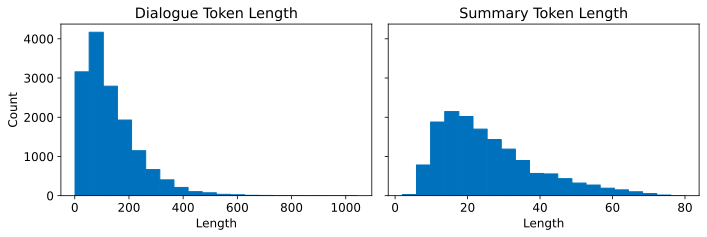

In [33]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [35]:
#hide_output
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

In [36]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, 
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [37]:
#hide_input

#id teacher-forcing
#alt Decoder input and label alignemt for text generation.
#caption Decoder input and label alignemt for text generation.
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

decoder_input          label
step                                                             
1                                            [PAD]   Transformers
2                              [PAD, Transformers]            are
3                         [PAD, Transformers, are]        awesome
4                [PAD, Transformers, are, awesome]            for
5           [PAD, Transformers, are, awesome, for]           text
6     [PAD, Transformers, are, awesome, for, text]  summarization

In [38]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [39]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', 
    num_train_epochs=1, 
    warmup_steps=500,
    per_device_train_batch_size=1, 
    per_device_eval_batch_size=1,
    weight_decay=0.01, 
    logging_steps=10, 
    push_to_hub=True,
    evaluation_strategy='steps', 
    eval_steps=500, 
    save_steps=1e6,
    gradient_accumulation_steps=16)

In [40]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [41]:
train_sample_samsum = dataset_samsum_pt["train"].select(range(20))
val_sample_samsum = dataset_samsum_pt["validation"].select(range(20))

In [42]:
# hide_output
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=train_sample_samsum, 
                  eval_dataset=val_sample_samsum)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/andreas/nlp-transformers-notebooks/pegasus-samsum is already a clone of https://huggingface.co/andreaschandra/pegasus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [43]:
# hide_output
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, dialogue, id. If summary, dialogue, id are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/home/andreas/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)




Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 3.3468, 'train_samples_per_second': 5.976, 'train_steps_per_second': 0.299, 'train_loss': 3.0760905742645264, 'epoch': 0.8}


TrainOutput(global_step=1, training_loss=3.0760905742645264, metrics={'train_runtime': 3.3468, 'train_samples_per_second': 5.976, 'train_steps_per_second': 0.299, 'train_loss': 3.0760905742645264, 'epoch': 0.8})

In [44]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

100%|██████████| 410/410 [20:42<00:00,  3.03s/it]


rouge1    rouge2    rougeL  rougeLsum
pegasus  0.281524  0.083681  0.219575   0.219657

In [45]:
# hide_input
pd.DataFrame(rouge_dict, index=[f"pegasus"])

rouge1    rouge2    rougeL  rougeLsum
pegasus  0.281524  0.083681  0.219575   0.219657

In [46]:
# hide_output
trainer.push_to_hub("Training complete!")

Saving model checkpoint to pegasus-samsum
Configuration saved in pegasus-samsum/config.json
Model weights saved in pegasus-samsum/pytorch_model.bin
tokenizer config file saved in pegasus-samsum/tokenizer_config.json
Special tokens file saved in pegasus-samsum/special_tokens_map.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Upload file pytorch_model.bin:   0%|          | 32.0k/2.13G [00:00<?, ?B/s]

Upload file spiece.model:   2%|1         | 32.0k/1.82M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.11k/3.11k [00:00<?, ?B/s]

To https://huggingface.co/andreaschandra/pegasus-samsum
   6f4e1d3..836cf01  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'samsum', 'type': 'samsum', 'args': 'samsum'}}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To https://huggingface.co/andreaschandra/pegasus-samsum
   836cf01..480c037  main -> main



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/andreaschandra/pegasus-samsum/commit/836cf01a93ddfd43423daf600a20024e510bc27e'

### Generating Dialogue Summaries

In [ ]:
# hide
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

## Conclusion